# Assignment 2: Water Quality Analysis

## Table of Contents

1) Importing necessary modules for the notebook

2) Dataset preprocessing

3) Discretization of numerical data

4) Parameter learning and Network structure

5) Model fitting and Generating Inferences

6) Assignment Question 1

7) Assignment Question 2

8) Assignment Question 3

9) Assignment Question 4



### 1) Importing necessary modules for the notebook

In [1]:
import pandas as pd
import numpy as np

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualWidthDiscretiser

import networkx as nx
import pylab as plt
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2) Dataset preprocessing

In [2]:
df=pd.read_csv("water_potability.csv")

In [3]:
#df = df.sample(frac = 1)
df.shape


(3276, 10)

In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
#We are filling the missing values using linear interpolation
df=df.interpolate(method ='linear', limit_direction ='forward')
list_of_col=list(df.columns)

In [7]:
df.isnull().sum()

ph                 1
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [8]:
df=df.dropna()
df_copy=df.copy()

In [9]:
df.shape

(3275, 10)

### 3) Discretization of numerical data

We are using PGMPY library for the creation of bayesian networks. Bayesian Networks dont support continuous data hence we need to make it as categorical. Discretization is the method of doing the above process.

As a general standard we will check which numerical features need to be binned, the feature which has more than, 32 unique values should be binned.

In [10]:
#Check the number of unique values of each column and if it is more than 32 adding to bin_list array
bin_list=[]
for col in df.columns:
    print(col," : ",len(df[col].unique()))
    if (len(df[col].unique())>32):
        bin_list.append(col)

ph  :  3275
Hardness  :  3275
Solids  :  3275
Chloramines  :  3275
Sulfate  :  3271
Conductivity  :  3275
Organic_carbon  :  3275
Trihalomethanes  :  3275
Turbidity  :  3275
Potability  :  2


As you can see, other than Potability every column is having more than 32 unique values hence we need to discretize these columns.


We have prepared the list of features (bin_list) which we will bin using EqualFrequencyDiscretiser (it divides continuous numerical variables into intervals that contain approximately the same proportion of observations) from feature engine library. 

In [11]:
#bin size = no of the bins
bin_size=13
disc = EqualFrequencyDiscretiser(q=bin_size, variables=bin_list)
df_binned=disc.fit(df[bin_list])
equalfrequency_discretizer_dict=disc.binner_dict_
bin_df_equalfrequency=pd.DataFrame.from_dict(equalfrequency_discretizer_dict,orient='index')

#### We have chosen bin size considering the computational power of our local machines. It may affect the accuracy , but always the higher the better.

In [12]:
#intervals of the bins
bin_df_equalfrequency

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
ph,-inf,4.943272,5.596204,6.035010,6.351935,6.641249,6.916905,7.182969,7.464354,7.770846,8.088553,8.550938,9.242816,inf
Hardness,-inf,150.075850,163.942931,174.665128,182.070819,187.796848,193.707850,199.421811,205.234834,211.622940,218.730484,228.164272,240.975763,inf
Solids,-inf,10924.926548,13371.925255,15176.790108,16913.207529,18509.259505,20116.945561,21828.797849,23623.734825,25677.484545,27925.049621,30972.602422,35297.605029,inf
Chloramines,-inf,4.945372,5.606304,6.046259,6.368978,6.669256,6.977542,7.276024,7.567617,7.845694,8.211672,8.663552,9.378504,inf
Sulfate,-inf,280.991633,297.324505,307.711002,316.674831,323.356503,329.318735,336.061398,342.935505,350.772151,360.006666,371.929404,388.754777,inf
Conductivity,-inf,315.131555,341.336839,360.706015,379.577734,397.224758,413.553578,430.390766,446.840390,468.401198,487.445898,512.039633,547.347089,inf
Organic_carbon,-inf,9.610242,10.971929,11.869504,12.577242,13.292507,13.939486,14.533460,15.216552,15.964921,16.764846,17.725625,18.940723,inf
Trihalomethanes,-inf,43.384513,50.574715,55.054829,59.296419,62.196576,65.093267,68.230885,71.150170,74.457228,77.935589,82.402998,88.686666,inf
Turbidity,-inf,2.859834,3.170288,3.396787,3.579317,3.735992,3.880668,4.040898,4.196688,4.363990,4.552945,4.765060,5.087031,inf


In [13]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.057858,6.635246,364.639673,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,360.762904,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0


The discretization is done , but to increase the meaning and easy querying of dataset we need to rename each value in each column corresponding to the range of bin it represents. The below code is for that 

In [14]:
j=0
big_label=[]
for col in bin_list:
    print(col,": Min = ",round(min(df[col].unique()),2)," Max = ", round(max(df[col].unique()),2))
    print()
    f_ele=str(round(min(df[col].unique()),2))+" to "+str(round(bin_df_equalfrequency[1][col],2))
    label=[]
    label.append(f_ele)
    for i in range(1,bin_size-1):
        ele=str(round(bin_df_equalfrequency[i][bin_list[j]],2))+" to "+str(round(bin_df_equalfrequency[i+1][bin_list[j]],2))
        label.append(ele)
    l_ele=str(round(bin_df_equalfrequency[i+1][bin_list[j]],2))+" to "+str(round(max(df[col].unique()),2))
    label.append(l_ele)
    df[col] = pd.cut(df[col],bin_size, labels= label)
    j+=1
    print(label)
    big_label.append(label)
    print()
        

ph : Min =  0.0  Max =  14.0

['0.0 to 4.94', '4.94 to 5.6', '5.6 to 6.04', '6.04 to 6.35', '6.35 to 6.64', '6.64 to 6.92', '6.92 to 7.18', '7.18 to 7.46', '7.46 to 7.77', '7.77 to 8.09', '8.09 to 8.55', '8.55 to 9.24', '9.24 to 14.0']

Hardness : Min =  47.43  Max =  323.12

['47.43 to 150.08', '150.08 to 163.94', '163.94 to 174.67', '174.67 to 182.07', '182.07 to 187.8', '187.8 to 193.71', '193.71 to 199.42', '199.42 to 205.23', '205.23 to 211.62', '211.62 to 218.73', '218.73 to 228.16', '228.16 to 240.98', '240.98 to 323.12']

Solids : Min =  320.94  Max =  61227.2

['320.94 to 10924.93', '10924.93 to 13371.93', '13371.93 to 15176.79', '15176.79 to 16913.21', '16913.21 to 18509.26', '18509.26 to 20116.95', '20116.95 to 21828.8', '21828.8 to 23623.73', '23623.73 to 25677.48', '25677.48 to 27925.05', '27925.05 to 30972.6', '30972.6 to 35297.61', '35297.61 to 61227.2']

Chloramines : Min =  0.35  Max =  13.13

['0.35 to 4.95', '4.95 to 5.61', '5.61 to 6.05', '6.05 to 6.37', '6.37 to 6.

In [15]:
#converted df
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,6.04 to 6.35,174.67 to 182.07,15176.79 to 16913.21,6.98 to 7.28,342.94 to 350.77,468.4 to 487.45,13.94 to 14.53,62.2 to 65.09,4.04 to 4.2,0
2,7.18 to 7.46,205.23 to 211.62,16913.21 to 18509.26,7.85 to 8.21,342.94 to 350.77,397.22 to 413.55,14.53 to 15.22,65.09 to 68.23,3.4 to 3.58,0
3,7.18 to 7.46,199.42 to 205.23,16913.21 to 18509.26,7.28 to 7.57,342.94 to 350.77,379.58 to 397.22,15.22 to 15.96,77.94 to 82.4,4.04 to 4.2,0
4,7.46 to 7.77,193.71 to 199.42,15176.79 to 16913.21,6.98 to 7.28,329.32 to 336.06,379.58 to 397.22,12.58 to 13.29,55.05 to 59.3,3.88 to 4.04,0
5,6.64 to 6.92,193.71 to 199.42,20116.95 to 21828.8,7.28 to 7.57,336.06 to 342.94,341.34 to 360.71,11.87 to 12.58,62.2 to 65.09,3.17 to 3.4,0


In [16]:
#df_train= pd.concat([df[:500],df[1411:]])
df_train= df[:3200]
df_test = df[3200:]
df_test = df_test.iloc[: , :-1]
#df.shape
#df_train.shape
#df_test.shape

### 4) Parameter learning and Network structure



#### Different types of parameter learning and tree generation techniques

1) Hill climb search

2) Tree search

3) Mmhc Estimator

4) Exhaustive search

We tried all of the algorithms and found that "Tree Search algorithm" with the estimator type "tan" is giving the maximum accuracy. Hence we are fixing that algorithm for our network structure generation 

Building tree: 100%|██████████████████████████| 45/45.0 [00:00<00:00, 169.47it/s]


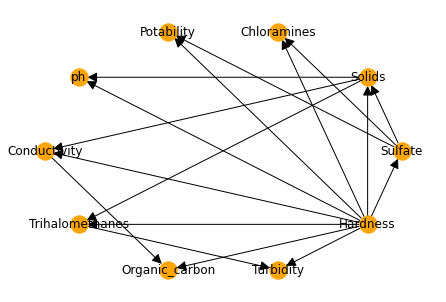

In [17]:
from pgmpy.estimators import TreeSearch


est = TreeSearch(df_train)

model = est.estimate(estimator_type='tan')

nx.draw_circular(model, with_labels=True, arrowsize=20,node_color="orange",

                 alpha=1)

plt.show()

In [18]:
#printing the edges according to the generated model
edges=list(model.edges())
edges

[('Sulfate', 'Solids'),
 ('Sulfate', 'Chloramines'),
 ('Sulfate', 'Potability'),
 ('Solids', 'ph'),
 ('Solids', 'Conductivity'),
 ('Solids', 'Trihalomethanes'),
 ('Conductivity', 'Organic_carbon'),
 ('Trihalomethanes', 'Turbidity'),
 ('Hardness', 'ph'),
 ('Hardness', 'Solids'),
 ('Hardness', 'Chloramines'),
 ('Hardness', 'Sulfate'),
 ('Hardness', 'Conductivity'),
 ('Hardness', 'Organic_carbon'),
 ('Hardness', 'Trihalomethanes'),
 ('Hardness', 'Turbidity'),
 ('Hardness', 'Potability')]

This network structure was giving very low accuracy on our test set. Hence we had to construct the bayesian network ourselves.

### Case Study on Parameters affecting the water quallity


To understand construct the network we did a casestudy of the domain. After going through several research papers and published articles  we came at the below conclusions on each of the affecting factor

1. pH value:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.


2. Hardness:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.


3. Solids (Total dissolved solids - TDS):
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.


4. Chloramines:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.


5. Sulfate:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.


6. Conductivity:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.


7. Organic_carbon:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.


8. Trihalomethanes:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.


9. Turbidity:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.


10. Potability:
Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.




From the above assumptions we came at the below connections between the factors

1) Ph → potability

2) Solids → hardness

3) Solids → potability

4) Chloramines → potability

5) Sulphate→ Solids

6) Solids → Conductivity

7) Organic_carbon → Potability

8) Organic_carbon → Chloramines


Based on the above connections we created the tree structure.


<Figure size 1080x720 with 0 Axes>

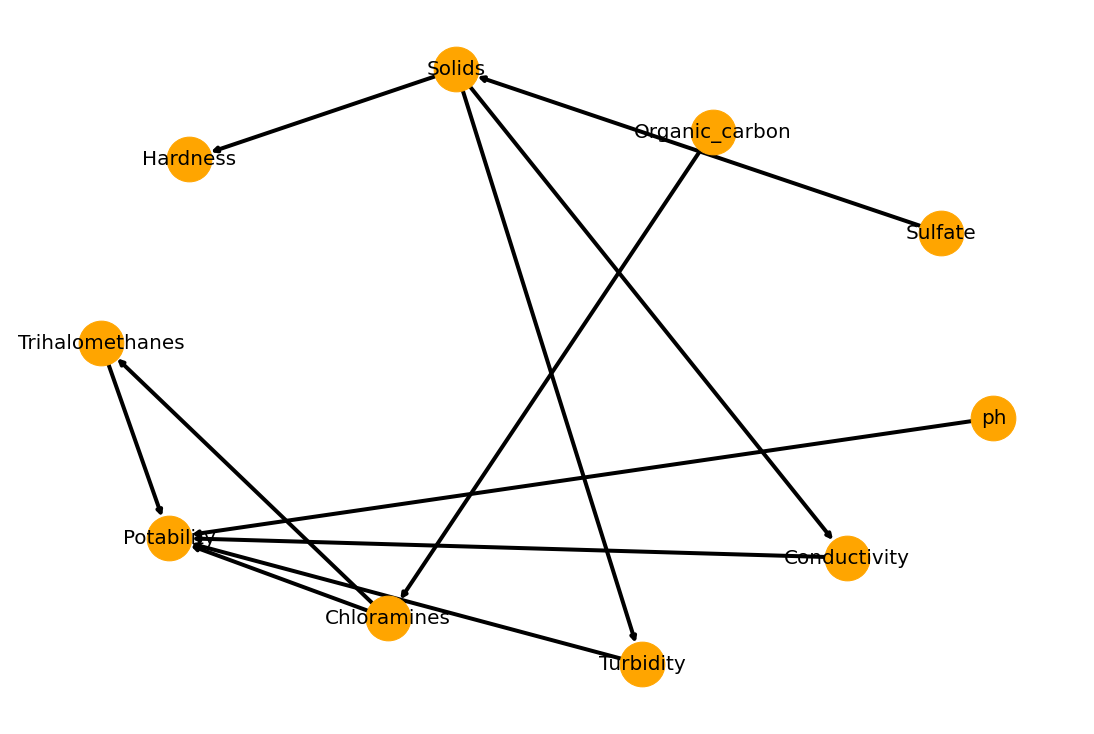

In [19]:
edges_manual=list([('ph', 'Potability'), ('Sulfate', 'Solids'),('Solids','Hardness'),('Solids','Turbidity'),
       ('Solids','Conductivity'),('Turbidity', 'Potability'),('Conductivity','Potability'),
       ('Organic_carbon','Chloramines'),('Chloramines','Trihalomethanes'),('Chloramines','Potability'),
      ('Trihalomethanes','Potability')])
manual_model = BayesianModel(edges_manual)
%matplotlib inline
plt.figure(figsize=(15,10))
nx.draw(manual_model, pos= nx.spring_layout(manual_model), with_labels=True, node_size=2000, node_color="orange", width = 4, font_size = 20)
plt.show()

### 5) Model fitting and Generating Inferences

In [20]:
bayesian_model = BayesianModel(edges_manual)

In [21]:
# Fitting the data to the model using Maximum Likelihood Estimator
bayesian_model.fit(df_train, estimator=MaximumLikelihoodEstimator)

In [22]:
#Defining the target varaible
target = 'Potability'

In [23]:
#Acc to our model and tree the parents of the target variable are
bayesian_model.get_parents(target)

['ph', 'Turbidity', 'Conductivity', 'Chloramines', 'Trihalomethanes']

In [24]:
# Doing exact inference using Variable Elimination
infer = VariableElimination(bayesian_model)

#### Joint Distribution and sulphate and potability

In [25]:
print(infer.query(variables=[target, 'Sulfate'], joint= True))

Eliminating: Organic_carbon: 100%|█████████████████| 7/7 [00:00<00:00, 17.79it/s]

+---------------------------+---------------+---------------------------+
| Sulfate                   | Potability    |   phi(Sulfate,Potability) |
+===========================+===============+===========================+
| Sulfate(129.0 to 280.99)  | Potability(0) |                    0.0002 |
+---------------------------+---------------+---------------------------+
| Sulfate(129.0 to 280.99)  | Potability(1) |                    0.0001 |
+---------------------------+---------------+---------------------------+
| Sulfate(280.99 to 297.32) | Potability(0) |                    0.0003 |
+---------------------------+---------------+---------------------------+
| Sulfate(280.99 to 297.32) | Potability(1) |                    0.0003 |
+---------------------------+---------------+---------------------------+
| Sulfate(297.32 to 307.71) | Potability(0) |                    0.0013 |
+---------------------------+---------------+---------------------------+
| Sulfate(297.32 to 307.71) | Potabili

In [26]:
#conditional probability distributions
bayesian_model.get_cpds()

[<TabularCPD representing P(ph:13) at 0x7fd9315cf8e0>,
 <TabularCPD representing P(Potability:2 | Chloramines:13, Conductivity:13, Trihalomethanes:13, Turbidity:13, ph:13) at 0x7fd93143b670>,
 <TabularCPD representing P(Sulfate:13) at 0x7fd9315cf280>,
 <TabularCPD representing P(Solids:13 | Sulfate:13) at 0x7fd932e53490>,
 <TabularCPD representing P(Hardness:13 | Solids:13) at 0x7fd932e53550>,
 <TabularCPD representing P(Turbidity:13 | Solids:13) at 0x7fd9314f4430>,
 <TabularCPD representing P(Conductivity:13 | Solids:13) at 0x7fd932ecb6a0>,
 <TabularCPD representing P(Organic_carbon:13) at 0x7fd9315cf970>,
 <TabularCPD representing P(Chloramines:13 | Organic_carbon:13) at 0x7fd931452f10>,
 <TabularCPD representing P(Trihalomethanes:13 | Chloramines:13) at 0x7fd9d009eca0>]

In [27]:
#Code for printing the cpd 
#print(bayesian_model.get_cpds("Potability"))

#### Local Independencies

In [28]:
model.local_independencies(list(df.columns))

(ph ⟂ Chloramines, Sulfate, Conductivity, Potability, Trihalomethanes, Organic_carbon, Turbidity | Solids, Hardness)
(Solids ⟂ Chloramines, Potability | Sulfate, Hardness)
(Chloramines ⟂ Solids, ph, Conductivity, Potability, Trihalomethanes, Organic_carbon, Turbidity | Sulfate, Hardness)
(Conductivity ⟂ ph, Chloramines, Sulfate, Potability, Turbidity, Trihalomethanes | Solids, Hardness)
(Organic_carbon ⟂ Solids, ph, Sulfate, Chloramines, Potability, Turbidity, Trihalomethanes | Hardness, Conductivity)
(Trihalomethanes ⟂ ph, Sulfate, Chloramines, Potability, Conductivity, Organic_carbon | Solids, Hardness)
(Turbidity ⟂ Solids, ph, Sulfate, Chloramines, Potability, Conductivity, Organic_carbon | Hardness, Trihalomethanes)
(Potability ⟂ Solids, ph, Chloramines, Conductivity, Turbidity, Trihalomethanes, Organic_carbon | Sulfate, Hardness)

### 6) Assignment Question 1


1. Construct a Bayesian Belief Network for the given data. [30% weightage]

<Figure size 1080x720 with 0 Axes>

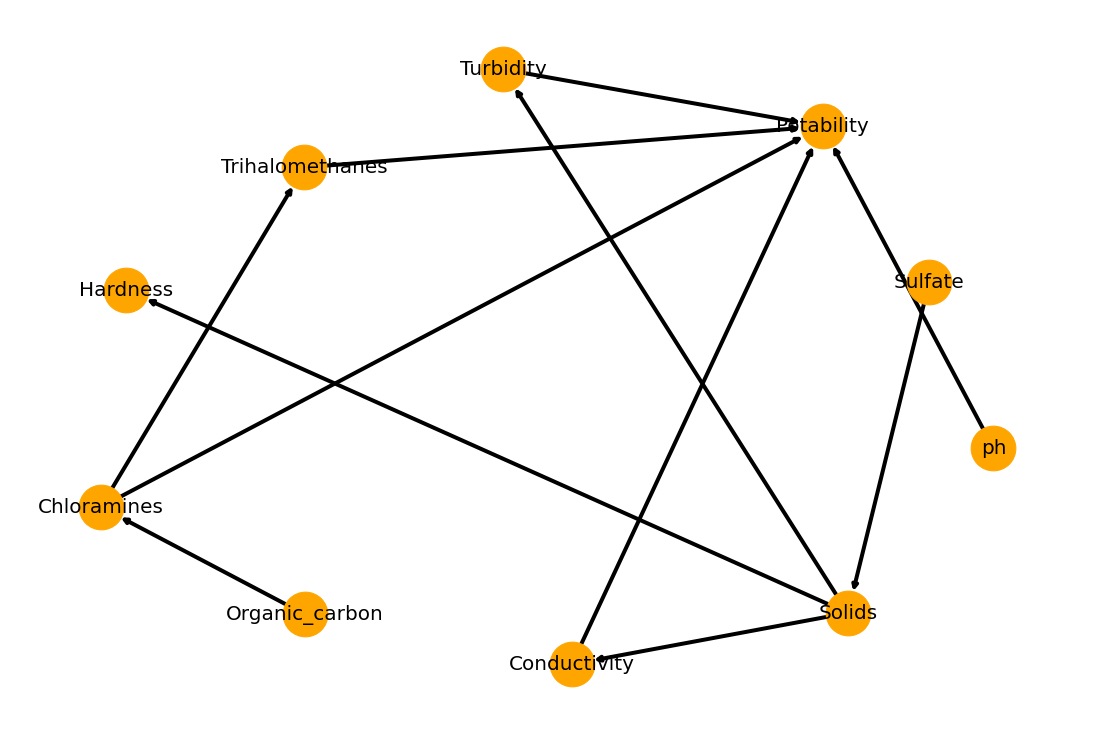

In [29]:
#Kindly refer to the steps and the process of creation of this network defined earlier

plt.figure(figsize=(15,10))
nx.draw(manual_model, pos= nx.spring_layout(manual_model), with_labels=True, node_size=2000, node_color="orange", width = 4, font_size = 20)
plt.show()

### 7) Assignment -- Question no 2:

Predict the water quality for the following data: [10%weightage]

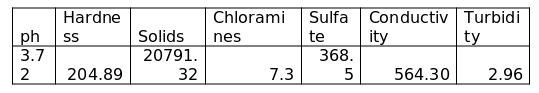

Here as we have discretized the data: hence we need to find the ranges the above variables belongs to . The below function is for that purpose


In [30]:
to_fetch=bin_df_equalfrequency.T

In [31]:
def variable(col,value):
    if (to_fetch[col][1]>value):
        return(str(round(min(df_copy[col].unique()),2))+" to "+str(round(bin_df_equalfrequency[1][col],2)))
    for i in range(2,len(to_fetch)-1):
        if (to_fetch[col][i])>value:
            return(str(round(bin_df_equalfrequency[i-1][col],2))+" to "+str(round(bin_df_equalfrequency[i][col],2)))
    else:
        return(str(round(bin_df_equalfrequency[i][col],2))+" to "+str(round(max(df_copy[col].unique()),2)))

Variable is a function which takes an input value and return the interval according to the bins.

In [32]:
ph=variable("ph",3.72)
hardness=variable("Hardness",204.89) 
solids=variable("Solids",20791.32)
chloramines=variable("Chloramines",7.3) 
sulfate=variable("Sulfate",368.5) 
conductivity=variable("Conductivity",564.30)
turbidity=variable("Turbidity",2.96) 

In [33]:
print("Mapping Question-2 Input values with the values in our dataset")
print("---------------------------------------------------")
print("Value of Ph           : ",ph)
print("Value of Hardness     : ",hardness)
print("Value of Solids       : ",solids)
print("Value of Chloramines  : ",chloramines)
print("Value of Sulfate      : ",sulfate)
print("Value of Conductivity : ",conductivity)
print("Value of Turbidity    : ",turbidity)

Mapping Question-2 Input values with the values in our dataset
---------------------------------------------------
Value of Ph           :  0.0 to 4.94
Value of Hardness     :  199.42 to 205.23
Value of Solids       :  20116.95 to 21828.8
Value of Chloramines  :  7.28 to 7.57
Value of Sulfate      :  360.01 to 371.93
Value of Conductivity :  547.35 to 753.34
Value of Turbidity    :  2.86 to 3.17


In [34]:
#predicting the water quality for the following data
#print(infer.query(variables=[target],evidence={"ph":ph,"Hardness":hardness,"Solids":solids,"Chloramines":chloramines,
                                               #"Sulfate":sulfate,"Conductivity":conductivity,"Turbidity":turbidity},show_progress=True))

In [35]:
#predicting the water quality for the following data
print(infer.map_query(variables=[target],evidence={"ph":ph,"Hardness":hardness,"Solids":solids,"Chloramines":chloramines,
                                               "Sulfate":sulfate,"Conductivity":conductivity,"Turbidity":turbidity}))

Eliminating: Trihalomethanes: 100%|███████████████| 1/1 [00:00<00:00, 544.43it/s]

{'Potability': 0}


Hence the water is Non Drinkable.

### 8)Assignment -- Question no 3

Infer the probability for the data with the following properties: [10%weightage]

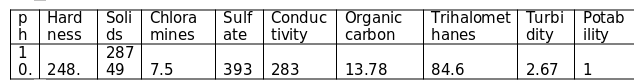

In [36]:
ph=variable("ph",10)
hardness=variable("Hardness",248) 
solids=variable("Solids",28749)
chloramines=variable("Chloramines",7.5) 
sulfate=variable("Sulfate",393) 
conductivity=variable("Conductivity",283)
turbidity=variable("Turbidity",2.67)
org_carbon=variable("Organic_carbon",13.78)
trihalo=variable("Trihalomethanes",84.6)
pot=1

In [37]:
print("Mapping Question-3 Input values with the values in our dataset")
print("--------------------------------------------------------------")
print("Value of Ph              : ",ph)
print("Value of Hardness        : ",hardness)
print("Value of Solids          : ",solids)
print("Value of Chloramines     : ",chloramines)
print("Value of Sulfate         : ",sulfate)
print("Value of Conductivity    : ",conductivity)
print("Value of Turbidity       : ",turbidity)
print("Value of Organic Carbon  : ",org_carbon)
print("Value of Trihalomethanes : ",trihalo)
print("Value of Potability      : ",pot)

Mapping Question-3 Input values with the values in our dataset
--------------------------------------------------------------
Value of Ph              :  9.24 to 14.0
Value of Hardness        :  240.98 to 323.12
Value of Solids          :  27925.05 to 30972.6
Value of Chloramines     :  7.28 to 7.57
Value of Sulfate         :  388.75 to 481.03
Value of Conductivity    :  181.48 to 315.13
Value of Turbidity       :  1.45 to 2.86
Value of Organic Carbon  :  13.29 to 13.94
Value of Trihalomethanes :  82.4 to 88.69
Value of Potability      :  1


we are asked to find the probability of occuring the above conditions. This can be done using chain rule 

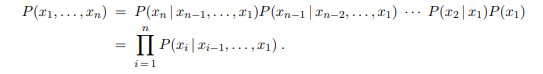

Acc: to chain rule 

P(ph,har,sol,chl,sul,con,tur,org,tri,pot)=  P(pot|tri,org,tur,con,sul,chl,sol,har,ph)* P(tri|org,tur,con,sul,chl,sol,har,ph)* P(org|tur,con,sul,chl,sol,har,ph) * P(tur|con,sul,chl,sol,har,ph) * P(con|sul,chl,sol,har,ph) * P(sul|chl,sol,har,ph) * P(chl|sol,har,ph) * P(sol|har,ph) * P(har|ph) * P(ph)

Then we need to find each of these values using infer method of variable elimination

#### P(pot|tri,org,tur,con,sul,chl,sol,har,ph)

In [38]:
print(infer.query(variables=["Potability"],evidence={"Trihalomethanes":trihalo,"Organic_carbon":org_carbon,"Turbidity":turbidity,
                                                     "Conductivity":conductivity,"Sulfate":sulfate,"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
term1=0.5

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.5000 |
+---------------+-------------------+
| Potability(1) |            0.5000 |
+---------------+-------------------+


Here we need is potability =1 
P(pot|tri,org,tur,con,sul,chl,sol,har,ph) = 0.5

#### P(tri|org,tur,con,sul,chl,sol,har,ph)

In [39]:
term_infer2=(infer.query(variables=["Trihalomethanes"],evidence={"Organic_carbon":org_carbon,"Turbidity":turbidity,
                                                     "Conductivity":conductivity,"Sulfate":sulfate,"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer2)
term2=term_infer2.values[big_label[list_of_col.index(term_infer2.variables[0])].index(trihalo)]
print(term2)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+------------------------+
| Trihalomethanes                 |   phi(Trihalomethanes) |
+=================================+========================+
| Trihalomethanes(0.74 to 43.38)  |                 0.0013 |
+---------------------------------+------------------------+
| Trihalomethanes(43.38 to 50.57) |                 0.0013 |
+---------------------------------+------------------------+
| Trihalomethanes(50.57 to 55.05) |                 0.0051 |
+---------------------------------+------------------------+
| Trihalomethanes(55.05 to 59.3)  |                 0.0360 |
+---------------------------------+------------------------+
| Trihalomethanes(59.3 to 62.2)   |                 0.0746 |
+---------------------------------+------------------------+
| Trihalomethanes(62.2 to 65.09)  |                 0.1583 |
+---------------------------------+------------------------+
| Trihalomethanes(65.09 to 68.23) |                 0.2239 |
+-----------------------

#### P(org|tur,con,sul,chl,sol,har,ph)

In [40]:
term_infe3=(infer.query(variables=["Organic_carbon"],evidence={"Turbidity":turbidity,
                                                     "Conductivity":conductivity,"Sulfate":sulfate,"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infe3)
term3=term_infe3.values[big_label[list_of_col.index(term_infe3.variables[0])].index(org_carbon)]
print(term3)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+--------------------------------+-----------------------+
| Organic_carbon                 |   phi(Organic_carbon) |
+================================+=======================+
| Organic_carbon(10.97 to 11.87) |                0.0219 |
+--------------------------------+-----------------------+
| Organic_carbon(11.87 to 12.58) |                0.0669 |
+--------------------------------+-----------------------+
| Organic_carbon(12.58 to 13.29) |                0.1300 |
+--------------------------------+-----------------------+
| Organic_carbon(13.29 to 13.94) |                0.2394 |
+--------------------------------+-----------------------+
| Organic_carbon(13.94 to 14.53) |                0.2304 |
+--------------------------------+-----------------------+
| Organic_carbon(14.53 to 15.22) |                0.1725 |
+--------------------------------+-----------------------+
| Organic_carbon(15.22 to 15.96) |                0.0901 |
+--------------------------------+----------------------

####  P(tur|con,sul,chl,sol,har,ph)

In [41]:
term_infer4=(infer.query(variables=["Turbidity"],evidence={"Conductivity":conductivity,"Sulfate":sulfate,"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer4)
term4=term_infer4.values[big_label[list_of_col.index(term_infer4.variables[0])].index(turbidity)]
print(term4)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-------------------------+------------------+
| Turbidity               |   phi(Turbidity) |
+=========================+==================+
| Turbidity(1.45 to 2.86) |           0.0000 |
+-------------------------+------------------+
| Turbidity(2.86 to 3.17) |           0.0000 |
+-------------------------+------------------+
| Turbidity(3.17 to 3.4)  |           0.0667 |
+-------------------------+------------------+
| Turbidity(3.4 to 3.58)  |           0.0667 |
+-------------------------+------------------+
| Turbidity(3.58 to 3.74) |           0.1333 |
+-------------------------+------------------+
| Turbidity(3.74 to 3.88) |           0.2000 |
+-------------------------+------------------+
| Turbidity(3.88 to 4.04) |           0.1333 |
+-------------------------+------------------+
| Turbidity(4.04 to 4.2)  |           0.1333 |
+-------------------------+------------------+
| Turbidity(4.2 to 4.36)  |           0.1333 |
+-------------------------+------------------+
| Turbidity(4

#### P(con|sul,chl,sol,har,ph)

In [42]:
term_infer5=(infer.query(variables=["Conductivity"],evidence={"Sulfate":sulfate,"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer5)
term5=term_infer5.values[big_label[list_of_col.index(term_infer5.variables[0])].index(conductivity)]
print(term5)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+--------------------------------+---------------------+
| Conductivity                   |   phi(Conductivity) |
+================================+=====================+
| Conductivity(181.48 to 315.13) |              0.0000 |
+--------------------------------+---------------------+
| Conductivity(315.13 to 341.34) |              0.0000 |
+--------------------------------+---------------------+
| Conductivity(341.34 to 360.71) |              0.0667 |
+--------------------------------+---------------------+
| Conductivity(360.71 to 379.58) |              0.2000 |
+--------------------------------+---------------------+
| Conductivity(379.58 to 397.22) |              0.2667 |
+--------------------------------+---------------------+
| Conductivity(397.22 to 413.55) |              0.2667 |
+--------------------------------+---------------------+
| Conductivity(413.55 to 430.39) |              0.0667 |
+--------------------------------+---------------------+
| Conductivity(430.39 to 446.84

#### P(sul|chl,sol,har,ph)

In [43]:
term_infer6=(infer.query(variables=["Sulfate"],evidence={"Chloramines":chloramines,
                                                     "Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer6)
term6=term_infer6.values[big_label[list_of_col.index(term_infer6.variables[0])].index(sulfate)]
print(term6)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------+----------------+
| Sulfate                   |   phi(Sulfate) |
+===========================+================+
| Sulfate(129.0 to 280.99)  |         0.0000 |
+---------------------------+----------------+
| Sulfate(280.99 to 297.32) |         0.0000 |
+---------------------------+----------------+
| Sulfate(297.32 to 307.71) |         0.0000 |
+---------------------------+----------------+
| Sulfate(307.71 to 316.67) |         0.0000 |
+---------------------------+----------------+
| Sulfate(316.67 to 323.36) |         0.0667 |
+---------------------------+----------------+
| Sulfate(323.36 to 329.32) |         0.0667 |
+---------------------------+----------------+
| Sulfate(329.32 to 336.06) |         0.4000 |
+---------------------------+----------------+
| Sulfate(336.06 to 342.94) |         0.2000 |
+---------------------------+----------------+
| Sulfate(342.94 to 350.77) |         0.1333 |
+---------------------------+----------------+
| Sulfate(350

#### P(chl|sol,har,ph)

In [44]:
term_infer7=(infer.query(variables=["Chloramines"],evidence={"Solids":solids,"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer7)
term7=term_infer7.values[big_label[list_of_col.index(term_infer7.variables[0])].index(chloramines)]
print(term7)

Eliminating: Organic_carbon: 100%|████████████████| 1/1 [00:00<00:00, 607.17it/s]

+----------------------------+--------------------+
| Chloramines                |   phi(Chloramines) |
+============================+====================+
| Chloramines(0.35 to 4.95)  |             0.0006 |
+----------------------------+--------------------+
| Chloramines(4.95 to 5.61)  |             0.0012 |
+----------------------------+--------------------+
| Chloramines(5.61 to 6.05)  |             0.0103 |
+----------------------------+--------------------+
| Chloramines(6.05 to 6.37)  |             0.0266 |
+----------------------------+--------------------+
| Chloramines(6.37 to 6.67)  |             0.0719 |
+----------------------------+--------------------+
| Chloramines(6.67 to 6.98)  |             0.1697 |
+----------------------------+--------------------+
| Chloramines(6.98 to 7.28)  |             0.2447 |
+----------------------------+--------------------+
| Chloramines(7.28 to 7.57)  |             0.2428 |
+----------------------------+--------------------+
| Chloramine

#### P(sol|har,ph) 

In [45]:
term_infer8=(infer.query(variables=["Solids"],evidence={"Hardness":hardness,"ph":ph},show_progress=True
                                                     ))
print(term_infer8)
term8=term_infer8.values[big_label[list_of_col.index(term_infer8.variables[0])].index(solids)]
print(term8)

Eliminating: Sulfate: 100%|███████████████████████| 1/1 [00:00<00:00, 413.72it/s]

+------------------------------+---------------+
| Solids                       |   phi(Solids) |
+==============================+===============+
| Solids(10924.93 to 13371.93) |        0.0000 |
+------------------------------+---------------+
| Solids(13371.93 to 15176.79) |        0.0000 |
+------------------------------+---------------+
| Solids(15176.79 to 16913.21) |        0.2857 |
+------------------------------+---------------+
| Solids(16913.21 to 18509.26) |        0.0000 |
+------------------------------+---------------+
| Solids(18509.26 to 20116.95) |        0.2857 |
+------------------------------+---------------+
| Solids(20116.95 to 21828.8)  |        0.1429 |
+------------------------------+---------------+
| Solids(21828.8 to 23623.73)  |        0.0000 |
+------------------------------+---------------+
| Solids(23623.73 to 25677.48) |        0.1429 |
+------------------------------+---------------+
| Solids(25677.48 to 27925.05) |        0.1429 |
+-------------------

#### P(har|ph) 

In [46]:
term_infer9=(infer.query(variables=["Hardness"],evidence={"ph":ph},show_progress=True))
print(term_infer9)
term9=term_infer9.values[big_label[list_of_col.index(term_infer9.variables[0])].index(hardness)]
print(term9)

Eliminating: Sulfate: 100%|███████████████████████| 2/2 [00:00<00:00, 346.74it/s]

+----------------------------+-----------------+
| Hardness                   |   phi(Hardness) |
+============================+=================+
| Hardness(150.08 to 163.94) |          0.0009 |
+----------------------------+-----------------+
| Hardness(163.94 to 174.67) |          0.0056 |
+----------------------------+-----------------+
| Hardness(174.67 to 182.07) |          0.0222 |
+----------------------------+-----------------+
| Hardness(182.07 to 187.8)  |          0.0612 |
+----------------------------+-----------------+
| Hardness(187.8 to 193.71)  |          0.1409 |
+----------------------------+-----------------+
| Hardness(193.71 to 199.42) |          0.2569 |
+----------------------------+-----------------+
| Hardness(199.42 to 205.23) |          0.2678 |
+----------------------------+-----------------+
| Hardness(205.23 to 211.62) |          0.1569 |
+----------------------------+-----------------+
| Hardness(211.62 to 218.73) |          0.0578 |
+-------------------

#### P(ph)

In [47]:
term_infer10=(infer.query(variables=["ph"],show_progress=True))
print(term_infer10)
term10=term_infer10.values[big_label[list_of_col.index(term_infer10.variables[0])].index(ph)]
print(term10)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+------------------+-----------+
| ph               |   phi(ph) |
+==================+===========+
| ph(0.0 to 4.94)  |    0.0013 |
+------------------+-----------+
| ph(4.94 to 5.6)  |    0.0016 |
+------------------+-----------+
| ph(5.6 to 6.04)  |    0.0041 |
+------------------+-----------+
| ph(6.04 to 6.35) |    0.0309 |
+------------------+-----------+
| ph(6.35 to 6.64) |    0.0841 |
+------------------+-----------+
| ph(6.64 to 6.92) |    0.2137 |
+------------------+-----------+
| ph(6.92 to 7.18) |    0.3006 |
+------------------+-----------+
| ph(7.18 to 7.46) |    0.2206 |
+------------------+-----------+
| ph(7.46 to 7.77) |    0.0959 |
+------------------+-----------+
| ph(7.77 to 8.09) |    0.0366 |
+------------------+-----------+
| ph(8.09 to 8.55) |    0.0084 |
+------------------+-----------+
| ph(8.55 to 9.24) |    0.0009 |
+------------------+-----------+
| ph(9.24 to 14.0) |    0.0013 |
+------------------+-----------+
0.00125


In [48]:
# Acc to chain rule
req_prob = term1 * term2 * term3 * term4 * term5 * term6 * term7 * term8 * term9 * term10
print("Probability of the given instance of variables : ",req_prob)

Probability of the given instance of variables :  0.0


### 9) Assignment Question 4

4.	Find the probability of the quality of water being good and the attributes take the following values: low ph, high in hardness, with high presence of solids, and other chemicals. [10%weightage]

In [50]:
print(infer.query(variables=["Potability"],evidence={"ph":big_label[0][0],"ph":big_label[0][1]},show_progress=True))

Eliminating: Chloramines: 100%|████████████████████| 7/7 [00:00<00:00, 56.11it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.5014 |
+---------------+-------------------+
| Potability(1) |            0.4986 |
+---------------+-------------------+


In [51]:
print(infer.query(variables=["Potability"],evidence={"Hardness":big_label[1][-1]},show_progress=True))

Eliminating: Solids: 100%|█████████████████████████| 8/8 [00:00<00:00, 29.08it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.5334 |
+---------------+-------------------+
| Potability(1) |            0.4666 |
+---------------+-------------------+


In [52]:
print(infer.query(variables=["Potability"],evidence={"Solids":big_label[2][-1]},show_progress=True))

Eliminating: Organic_carbon: 100%|█████████████████| 6/6 [00:00<00:00, 47.62it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.5479 |
+---------------+-------------------+
| Potability(1) |            0.4521 |
+---------------+-------------------+


In [53]:
print(infer.query(variables=["Potability"],evidence={"Chloramines":big_label[3][-2],"Chloramines":big_label[3][-1]},show_progress=True))

Eliminating: Trihalomethanes: 100%|███████████████| 6/6 [00:00<00:00, 120.03it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.4975 |
+---------------+-------------------+
| Potability(1) |            0.5025 |
+---------------+-------------------+


In [54]:
print(infer.query(variables=["Potability"],evidence={"Trihalomethanes":big_label[7][-1]},show_progress=True))

Eliminating: Chloramines: 100%|███████████████████| 7/7 [00:00<00:00, 134.97it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.4990 |
+---------------+-------------------+
| Potability(1) |            0.5010 |
+---------------+-------------------+


In [55]:
print(infer.query(variables=["Potability"],evidence={"Sulfate":big_label[4][-1], "Sulfate":big_label[4][-1]},show_progress=True))

Eliminating: Chloramines: 100%|████████████████████| 7/7 [00:00<00:00, 32.65it/s]

+---------------+-------------------+
| Potability    |   phi(Potability) |
+===============+===================+
| Potability(0) |            0.5321 |
+---------------+-------------------+
| Potability(1) |            0.4679 |
+---------------+-------------------+
